In [1]:
import pandas as pd

df = pd.read_csv('ONGB_EvalData_CLEANED.csv')
print("Columns:")
for col in df.columns:
    print(f"  {col}")
print(f"\nShape: {df.shape}")

Columns:
  ANON_ID
  Birthdate
  Gen
  Eth_1718
  Fluency_1718
  SpEd_1718
  SiteName_1718
  School Address_1718
  City_1718
  Zip_1718
  Grade_1718
  AttRate_1718
  DaysEnr_1718
  DaysAbs_1718
  Susp_1718
  Address_1718
  City_1718.1
  Zip_1718.1
  CurrWeightedTotGPA_1718
  SED_1718
  Eth_1819
  Fluency_1819
  SpEd_1819
  SiteName_1819
  School Address_1819
  City_1819
  Zip_1819
  Grade_1819
  AttRate_1819
  DaysEnr_1819
  DaysAbs_1819
  Susp_1819
  Address_1819
  City_1819.1
  Zip_1819.1
  CurrWeightedTotGPA_1819
  SED_1819
  Eth_1920
  Fluency_1920
  SpEd_1920
  SiteName_1920
  School Address_1920
  City_1920
  Zip_1920
  Grade_1920
  AttRate_1920
  DaysEnr_1920
  DaysAbs_1920
  Susp_1920
  Address_1920
  City_1920.1
  Zip_1920.1
  CurrWeightedTotGPA_1920
  SED_1920
  Eth_2021
  Fluency_2021
  SpEd_2021
  SiteName_2021
  School Address_2021
  City_2021
  Zip_2021
  Grade_2021
  AttRate_2021
  DaysEnr_2021
  DaysAbs_2021
  Susp_2021
  Address_2021
  City_2021.1
  Zip_2021.1
  CurrWe

/var/folders/vx/xc7347n175s50g85_65zycxc0000gn/T/ipykernel_54925/2100138324.py:3: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ONGB_EvalData_CLEANED.csv')


In [4]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.0 MB/s eta 0:00:00a 0:00:01


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# -- 1. LOAD ------------------------------------------------------------------
df = pd.read_csv('ONGB_EvalData_CLEANED.csv', low_memory=False)
print(f"Loaded: {df.shape}")

# -- 2. TARGET ----------------------------------------------------------------
TARGET = 'AttRate_2324'

if TARGET not in df.columns:
    att_cols = sorted([c for c in df.columns if 'AttRate' in c])
    TARGET = att_cols[-1]
    print(f"Using target: {TARGET}")

df = df.dropna(subset=[TARGET])
y = df[TARGET]

# -- 3. FEATURES --------------------------------------------------------------
drop_cols = ['ANON_ID', 'Birthdate', TARGET]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Encode categoricals
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Force all columns to numeric, coerce anything unparseable to NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Fill NaN with column median, then fill any remaining with 0
X = X.fillna(X.median(numeric_only=True))
X = X.fillna(0)

print(f"NaNs remaining: {X.isna().sum().sum()}")
print(f"Features: {X.shape[1]}  |  Rows: {X.shape[0]}")

# -- 4. SPLIT -----------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -- 5. LINEAR REGRESSION -----------------------------------------------------
print("\n--- Linear Regression ---")
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print(f"  MAE : {mean_absolute_error(y_test, lr_preds):.4f}")
print(f"  R2  : {r2_score(y_test, lr_preds):.4f}")

lr_importance = pd.Series(np.abs(lr.coef_), index=X.columns)
print("\n  Top 10 Features:")
print(lr_importance.nlargest(10).to_string())

# -- 6. XGBOOST ---------------------------------------------------------------
print("\n--- XGBoost ---")
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
xgb_preds = xgb_model.predict(X_test)
print(f"  MAE : {mean_absolute_error(y_test, xgb_preds):.4f}")
print(f"  R2  : {r2_score(y_test, xgb_preds):.4f}")

xgb_importance = pd.Series(xgb_model.feature_importances_, index=X.columns)
print("\n  Top 10 Features:")
print(xgb_importance.nlargest(10).to_string())

# -- 7. SAVE PREDICTIONS ------------------------------------------------------
results = X_test.copy()
results[TARGET] = y_test.values
results['LR_Predicted'] = lr_preds
results['XGB_Predicted'] = xgb_preds
results.to_csv('predictions.csv', index=False)
print("\nPredictions saved to predictions.csv")

# -- 8. FUTURE PREDICTIONS ----------------------------------------------------
full_X = df.drop(columns=[c for c in drop_cols if c in df.columns])
for col in full_X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    full_X[col] = le.fit_transform(full_X[col].astype(str))
full_X = full_X.apply(pd.to_numeric, errors='coerce')
full_X = full_X.fillna(full_X.median(numeric_only=True))
full_X = full_X.fillna(0)

df['XGB_Predicted_AttRate'] = xgb_model.predict(full_X)
df[['ANON_ID', 'XGB_Predicted_AttRate']].to_csv('future_predictions.csv', index=False)
print(f"Future predictions saved for {len(df)} students.")

Loaded: (79460, 143)
NaNs remaining: 0
Features: 140  |  Rows: 36695

--- Linear Regression ---
  MAE : 0.0232
  R2  : 0.8333

  Top 10 Features:
AttRate_2223       0.135315
City_2223          0.026429
AttRate_2122       0.025985
ChronicAbs_2324    0.023061
AttRate_1920       0.020034
City_2021          0.018200
AttRate_1819       0.017267
Age_2324           0.016616
Age_1920           0.016616
Age_1718           0.013233

--- XGBoost ---
  MAE : 0.0023
  R2  : 0.9961

  Top 10 Features:
ChronicAbs_2324            0.326871
DaysAbs_2324               0.240119
DaysEnr_2324               0.070257
CurrWeightedTotGPA_2324    0.035478
City_2223.1                0.023498
CurrWeightedTotGPA_2223    0.020812
AttRate_2223               0.019623
ChronicAbs_2223            0.018977
Age_1920                   0.010595
School Address_2223        0.009826

Predictions saved to predictions.csv
Future predictions saved for 36695 students.


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# -- 1. LOAD ------------------------------------------------------------------
df = pd.read_csv('ONGB_EvalData_CLEANED.csv', low_memory=False)
print(f"Loaded: {df.shape}")

# -- 2. TARGET ----------------------------------------------------------------
TARGET = 'AttRate_2324'

if TARGET not in df.columns:
    att_cols = sorted([c for c in df.columns if 'AttRate' in c])
    TARGET = att_cols[-1]
    print(f"Using target: {TARGET}")

# Split into known and unknown
known = df.dropna(subset=[TARGET])
unknown = df[df[TARGET].isna()].copy()
print(f"Students with 2324 data: {len(known)}")
print(f"Students without 2324 data: {len(unknown)}")

y = known[TARGET]

# -- 3. FEATURES --------------------------------------------------------------
drop_cols = ['ANON_ID', 'Birthdate', TARGET]

def prepare_X(data):
    X = data.drop(columns=[c for c in drop_cols if c in data.columns])
    for col in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.fillna(X.median(numeric_only=True))
    X = X.fillna(0)
    return X

X_known = prepare_X(known)
X_unknown = prepare_X(unknown)

# Align columns in case of mismatch
X_unknown = X_unknown.reindex(columns=X_known.columns, fill_value=0)

print(f"NaNs in known: {X_known.isna().sum().sum()}")
print(f"NaNs in unknown: {X_unknown.isna().sum().sum()}")
print(f"Features: {X_known.shape[1]}  |  Training rows: {X_known.shape[0]}")

# -- 4. SPLIT -----------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_known, y, test_size=0.2, random_state=42
)

# -- 5. LINEAR REGRESSION -----------------------------------------------------
print("\n--- Linear Regression ---")
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print(f"  MAE : {mean_absolute_error(y_test, lr_preds):.4f}")
print(f"  R2  : {r2_score(y_test, lr_preds):.4f}")

lr_importance = pd.Series(np.abs(lr.coef_), index=X_known.columns)
print("\n  Top 10 Features:")
print(lr_importance.nlargest(10).to_string())

# -- 6. XGBOOST ---------------------------------------------------------------
print("\n--- XGBoost ---")
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
xgb_preds = xgb_model.predict(X_test)
print(f"  MAE : {mean_absolute_error(y_test, xgb_preds):.4f}")
print(f"  R2  : {r2_score(y_test, xgb_preds):.4f}")

xgb_importance = pd.Series(xgb_model.feature_importances_, index=X_known.columns)
print("\n  Top 10 Features:")
print(xgb_importance.nlargest(10).to_string())

# -- 7. SAVE TEST PREDICTIONS -------------------------------------------------
results = X_test.copy()
results[TARGET] = y_test.values
results['LR_Predicted'] = lr_preds
results['XGB_Predicted'] = xgb_preds
results.to_csv('predictions.csv', index=False)
print("\nTest set predictions saved to predictions.csv")

# -- 8. PREDICT ALL STUDENTS --------------------------------------------------
# Students with known 2324 data
known_out = known[['ANON_ID']].copy()
known_out['XGB_Predicted_AttRate'] = xgb_model.predict(X_known)
known_out['Has_Actual_2324'] = True
known_out['Actual_AttRate_2324'] = y.values

# Students without 2324 data
unknown_out = unknown[['ANON_ID']].copy()
unknown_out['XGB_Predicted_AttRate'] = xgb_model.predict(X_unknown)
unknown_out['Has_Actual_2324'] = False
unknown_out['Actual_AttRate_2324'] = np.nan

# Combine and save
all_predictions = pd.concat([known_out, unknown_out], ignore_index=True)
all_predictions.to_csv('all_predictions.csv', index=False)
print(f"All predictions saved for {len(all_predictions)} students to all_predictions.csv")

Loaded: (79460, 143)
Students with 2324 data: 36695
Students without 2324 data: 42765
NaNs in known: 0
NaNs in unknown: 0
Features: 140  |  Training rows: 36695

--- Linear Regression ---
  MAE : 0.0232
  R2  : 0.8333

  Top 10 Features:
AttRate_2223       0.135315
City_2223          0.026429
AttRate_2122       0.025985
ChronicAbs_2324    0.023061
AttRate_1920       0.020034
City_2021          0.018200
AttRate_1819       0.017267
Age_2324           0.016616
Age_1920           0.016616
Age_1718           0.013233

--- XGBoost ---
  MAE : 0.0023
  R2  : 0.9961

  Top 10 Features:
ChronicAbs_2324            0.326871
DaysAbs_2324               0.240119
DaysEnr_2324               0.070257
CurrWeightedTotGPA_2324    0.035478
City_2223.1                0.023498
CurrWeightedTotGPA_2223    0.020812
AttRate_2223               0.019623
ChronicAbs_2223            0.018977
Age_1920                   0.010595
School Address_2223        0.009826

Test set predictions saved to predictions.csv
All pred

 Threshold  Precision  Recall    F1  Flagged
      0.80      1.000   0.445 0.616     1081
      0.81      1.000   0.473 0.642     1148
      0.82      1.000   0.511 0.676     1240
      0.83      1.000   0.550 0.709     1334
      0.84      1.000   0.598 0.749     1452
      0.85      1.000   0.639 0.779     1550
      0.86      1.000   0.696 0.820     1688
      0.87      1.000   0.761 0.865     1848
      0.88      1.000   0.845 0.916     2052
      0.89      1.000   0.941 0.969     2283
      0.90      0.999   1.000 1.000     2429
      0.91      0.906   1.000 0.951     2678
      0.92      0.803   1.000 0.891     3021
      0.93      0.702   1.000 0.825     3459
      0.94      0.613   1.000 0.760     3956
      0.95      0.550   1.000 0.710     4412
      0.96      0.498   1.000 0.665     4873

Best threshold by F1: 0.9
  Precision : 0.999  (of students flagged, how many are truly at-risk)
  Recall    : 1.0  (of truly at-risk students, how many we caught)
  F1        : 1.0
  Flagg

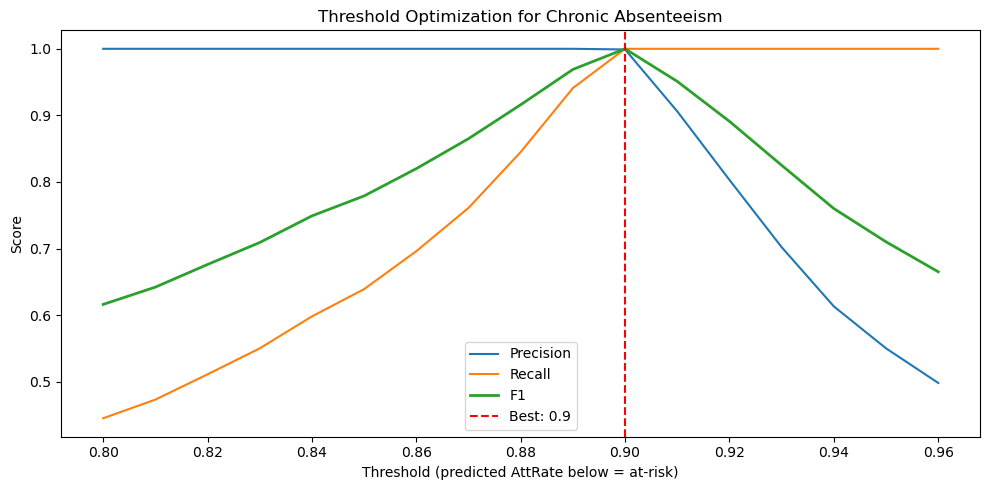

Plot saved to threshold_analysis.png


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Use test set where we have actual values
y_actual_binary = (y_test < 0.90).astype(int)  # 1 = chronically absent
xgb_att_preds = xgb_model.predict(X_test)

thresholds = np.arange(0.80, 0.97, 0.01)
results = []

for thresh in thresholds:
    y_pred_binary = (xgb_att_preds < thresh).astype(int)
    precision = precision_score(y_actual_binary, y_pred_binary, zero_division=0)
    recall = recall_score(y_actual_binary, y_pred_binary, zero_division=0)
    f1 = f1_score(y_actual_binary, y_pred_binary, zero_division=0)
    flagged = y_pred_binary.sum()
    results.append({'Threshold': round(thresh, 2), 'Precision': round(precision, 3),
                    'Recall': round(recall, 3), 'F1': round(f1, 3), 'Flagged': flagged})

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

best = results_df.loc[results_df['F1'].idxmax()]
print(f"\nBest threshold by F1: {best['Threshold']}")
print(f"  Precision : {best['Precision']}  (of students flagged, how many are truly at-risk)")
print(f"  Recall    : {best['Recall']}  (of truly at-risk students, how many we caught)")
print(f"  F1        : {best['F1']}")
print(f"  Flagged   : {int(best['Flagged'])} students in test set")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision')
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall')
plt.plot(results_df['Threshold'], results_df['F1'], label='F1', linewidth=2)
plt.axvline(best['Threshold'], color='red', linestyle='--', label=f"Best: {best['Threshold']}")
plt.xlabel('Threshold (predicted AttRate below = at-risk)')
plt.ylabel('Score')
plt.title('Threshold Optimization for Chronic Absenteeism')
plt.legend()
plt.tight_layout()
plt.savefig('threshold_analysis.png', dpi=150)
plt.show()
print("Plot saved to threshold_analysis.png")

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

xgb_att_preds = xgb_model.predict(X_test)

# -- SEVERITY BAND CLASSIFICATION ---------------------------------------------
def classify_severity(rate):
    if rate >= 0.90:
        return 'On Track'
    elif rate >= 0.80:
        return 'Chronic'
    elif rate >= 0.70:
        return 'High Chronic'
    else:
        return 'Severe'

y_test_bands = y_test.apply(classify_severity)
y_pred_bands = pd.Series(xgb_att_preds, index=y_test.index).apply(classify_severity)

# -- BAND ACCURACY ------------------------------------------------------------
print("=== Severity Band Classification ===\n")
band_results = pd.DataFrame({
    'Actual': y_test_bands,
    'Predicted': y_pred_bands
})

accuracy = (band_results['Actual'] == band_results['Predicted']).mean()
print(f"Overall Band Accuracy: {accuracy:.2%}\n")

# Per-band precision, recall, F1
from sklearn.metrics import classification_report
print(classification_report(y_test_bands, y_pred_bands,
      target_names=['On Track', 'Chronic', 'High Chronic', 'Severe']))

# -- BINARY CHRONIC FLAG (federal definition >= 0.90) -------------------------
print("=== Federal Chronic Flag (< 0.90) ===\n")
actual_chronic = (y_test < 0.90).astype(int)
pred_chronic   = (pd.Series(xgb_att_preds) < 0.90).astype(int)

print(f"  Precision : {precision_score(actual_chronic, pred_chronic):.3f}")
print(f"  Recall    : {recall_score(actual_chronic, pred_chronic):.3f}")
print(f"  F1        : {f1_score(actual_chronic, pred_chronic):.3f}")

cm = confusion_matrix(actual_chronic, pred_chronic)
print(f"\n  Confusion Matrix:")
print(f"                  Pred: On Track   Pred: Chronic")
print(f"  Actual On Track      {cm[0][0]:>6}          {cm[0][1]:>6}")
print(f"  Actual Chronic       {cm[1][0]:>6}          {cm[1][1]:>6}")

# -- APPLY BANDS TO ALL PREDICTIONS -------------------------------------------
all_predictions['Severity_Band'] = all_predictions['XGB_Predicted_AttRate'].apply(classify_severity)
print("\n=== Predicted Severity Distribution (all 79,460 students) ===")
print(all_predictions['Severity_Band'].value_counts().to_string())

all_predictions.to_csv('all_predictions.csv', index=False)
print("\nUpdated all_predictions.csv saved.")

=== Severity Band Classification ===

Overall Band Accuracy: 99.22%

              precision    recall  f1-score   support

    On Track       1.00      0.98      0.99      1373
     Chronic       0.94      0.95      0.94       484
High Chronic       1.00      1.00      1.00      4912
      Severe       0.96      1.00      0.98       570

    accuracy                           0.99      7339
   macro avg       0.97      0.98      0.98      7339
weighted avg       0.99      0.99      0.99      7339

=== Federal Chronic Flag (< 0.90) ===

  Precision : 0.999
  Recall    : 1.000
  F1        : 1.000

  Confusion Matrix:
                  Pred: On Track   Pred: Chronic
  Actual On Track        4910               2
  Actual Chronic            0            2427

=== Predicted Severity Distribution (all 79,460 students) ===
Severity_Band
On Track        67451
Chronic          6841
Severe           2829
High Chronic     2339

Updated all_predictions.csv saved.


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# -- 1. LOAD ------------------------------------------------------------------
df = pd.read_csv('ONGB_EvalData_CLEANED.csv', low_memory=False)
print(f"Loaded: {df.shape}")

# -- 2. TARGET ----------------------------------------------------------------
TARGET = 'AttRate_2324'

if TARGET not in df.columns:
    att_cols = sorted([c for c in df.columns if 'AttRate' in c])
    TARGET = att_cols[-1]
    print(f"Using target: {TARGET}")

known = df.dropna(subset=[TARGET])
unknown = df[df[TARGET].isna()].copy()
print(f"Students with 2324 data: {len(known)}")
print(f"Students without 2324 data: {len(unknown)}")

y = known[TARGET]

# -- 3. FEATURES (leakage removed) -------------------------------------------
drop_cols = ['ANON_ID', 'Birthdate', TARGET, 'ChronicAbs_2324']

def prepare_X(data):
    X = data.drop(columns=[c for c in drop_cols if c in data.columns])
    for col in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.fillna(X.median(numeric_only=True))
    X = X.fillna(0)
    return X

X_known = prepare_X(known)
X_unknown = prepare_X(unknown)
X_unknown = X_unknown.reindex(columns=X_known.columns, fill_value=0)

print(f"NaNs in known: {X_known.isna().sum().sum()}")
print(f"NaNs in unknown: {X_unknown.isna().sum().sum()}")
print(f"Features: {X_known.shape[1]}  |  Training rows: {X_known.shape[0]}")

# -- 4. SPLIT -----------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_known, y, test_size=0.2, random_state=42
)

# -- 5. LINEAR REGRESSION -----------------------------------------------------
print("\n--- Linear Regression ---")
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print(f"  MAE : {mean_absolute_error(y_test, lr_preds):.4f}")
print(f"  R2  : {r2_score(y_test, lr_preds):.4f}")

lr_importance = pd.Series(np.abs(lr.coef_), index=X_known.columns)
print("\n  Top 10 Features:")
print(lr_importance.nlargest(10).to_string())

# -- 6. XGBOOST ---------------------------------------------------------------
print("\n--- XGBoost ---")
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
xgb_preds = xgb_model.predict(X_test)
print(f"  MAE : {mean_absolute_error(y_test, xgb_preds):.4f}")
print(f"  R2  : {r2_score(y_test, xgb_preds):.4f}")

xgb_importance = pd.Series(xgb_model.feature_importances_, index=X_known.columns)
print("\n  Top 10 Features:")
print(xgb_importance.nlargest(10).to_string())

# -- 7. SEVERITY BANDS --------------------------------------------------------
def classify_severity(rate):
    if rate >= 0.90:
        return 'On Track'
    elif rate >= 0.80:
        return 'Chronic'
    elif rate >= 0.70:
        return 'High Chronic'
    else:
        return 'Severe'

xgb_att_preds = xgb_model.predict(X_test)
y_test_bands = y_test.apply(classify_severity)
y_pred_bands = pd.Series(xgb_att_preds, index=y_test.index).apply(classify_severity)

print("\n=== Severity Band Classification ===\n")
accuracy = (y_test_bands == y_pred_bands).mean()
print(f"Overall Band Accuracy: {accuracy:.2%}\n")
print(classification_report(y_test_bands, y_pred_bands))

print("=== Federal Chronic Flag (< 0.90) ===\n")
actual_chronic = (y_test < 0.90).astype(int)
pred_chronic = (pd.Series(xgb_att_preds) < 0.90).astype(int)
print(f"  Precision : {precision_score(actual_chronic, pred_chronic):.3f}")
print(f"  Recall    : {recall_score(actual_chronic, pred_chronic):.3f}")
print(f"  F1        : {f1_score(actual_chronic, pred_chronic):.3f}")

cm = confusion_matrix(actual_chronic, pred_chronic)
print(f"\n  Confusion Matrix:")
print(f"                  Pred: On Track   Pred: Chronic")
print(f"  Actual On Track      {cm[0][0]:>6}          {cm[0][1]:>6}")
print(f"  Actual Chronic       {cm[1][0]:>6}          {cm[1][1]:>6}")

# -- 8. PREDICT ALL STUDENTS --------------------------------------------------
known_out = known[['ANON_ID']].copy()
known_out['XGB_Predicted_AttRate'] = xgb_model.predict(X_known)
known_out['Has_Actual_2324'] = True
known_out['Actual_AttRate_2324'] = y.values

unknown_out = unknown[['ANON_ID']].copy()
unknown_out['XGB_Predicted_AttRate'] = xgb_model.predict(X_unknown)
unknown_out['Has_Actual_2324'] = False
unknown_out['Actual_AttRate_2324'] = np.nan

all_predictions = pd.concat([known_out, unknown_out], ignore_index=True)
all_predictions['Severity_Band'] = all_predictions['XGB_Predicted_AttRate'].apply(classify_severity)

print("\n=== Predicted Severity Distribution (all 79,460 students) ===")
print(all_predictions['Severity_Band'].value_counts().to_string())

all_predictions.to_csv('all_predictions.csv', index=False)
print("\nAll predictions saved to all_predictions.csv")

Loaded: (79460, 143)
Students with 2324 data: 36695
Students without 2324 data: 42765
NaNs in known: 0
NaNs in unknown: 0
Features: 139  |  Training rows: 36695

--- Linear Regression ---
  MAE : 0.0211
  R2  : 0.8169

  Top 10 Features:
AttRate_2223    0.135341
City_2223       0.028981
AttRate_2122    0.020986
City_2021       0.020268
AttRate_1819    0.020252
Age_2324        0.016114
Age_1920        0.016114
Age_1718        0.014817
Age_2122        0.014817
AttRate_1920    0.012141

--- XGBoost ---
  MAE : 0.0024
  R2  : 0.9962

  Top 10 Features:
DaysAbs_2324               0.397080
DaysEnr_2324               0.101918
AttRate_2223               0.074673
CurrWeightedTotGPA_2324    0.051995
Zip_2324                   0.035149
SED_Binary_1920            0.032042
SED_2021                   0.020209
SiteName_2324              0.012723
SiteName_2223              0.011979
DaysAbs_2223               0.011582

=== Severity Band Classification ===

Overall Band Accuracy: 98.34%

              p

Early Warning System — at the start of a school year, run the model on all enrolled students using their historical data. Flag anyone predicted below 0.90 for proactive outreach before they accumulate absences.
Tiered Intervention — use your severity bands to prioritize:

Severe (< 0.70) — immediate case management, home visits
High Chronic (0.70-0.80) — counselor check-ins, attendance contracts
Chronic (0.80-0.90) — teacher monitoring, family communication
On Track (≥ 0.90) — no action needed

Mid-year course correction — if you get partial attendance data (say after the first month), you could retrain the model with that included and get even sharper predictions for the rest of the year.
The key advantage here is lead time — instead of flagging a student as chronically absent in May when it's too late, you're identifying them in August or September when intervention can actually change the outcome.


In [11]:
# -- EARLY WARNING INTERVENTION LIST ------------------------------------------

# Pull unknown students (no 2324 data) with their predicted attendance
early_warning = unknown[['ANON_ID']].copy()
early_warning['Predicted_AttRate'] = xgb_model.predict(X_unknown)
early_warning['Severity_Band'] = early_warning['Predicted_AttRate'].apply(classify_severity)

# Add useful historical context columns if they exist
context_cols = [
    'Gen', 'Eth_2223', 'Grade_2223', 'SiteName_2223',
    'AttRate_2223', 'AttRate_2122', 'AttRate_2021',
    'SED_2223', 'SpEd_2223', 'Fluency_2223'
]
for col in context_cols:
    if col in unknown.columns:
        early_warning[col] = unknown[col].values

# Sort by risk (lowest predicted attendance = highest risk first)
early_warning = early_warning.sort_values('Predicted_AttRate', ascending=True)

# Add risk rank
early_warning['Risk_Rank'] = range(1, len(early_warning) + 1)

# Summary
print("=== Early Warning Summary ===\n")
print(early_warning['Severity_Band'].value_counts().to_string())
print(f"\nTotal students flagged as Chronic or worse: "
      f"{(early_warning['Severity_Band'] != 'On Track').sum()}")

# Save full list
early_warning.to_csv('early_warning_intervention_list.csv', index=False)
print(f"\nFull list saved to early_warning_intervention_list.csv")

# Save high priority only (Chronic or worse)
high_priority = early_warning[early_warning['Severity_Band'] != 'On Track']
high_priority.to_csv('high_priority_students.csv', index=False)
print(f"High priority list saved to high_priority_students.csv ({len(high_priority)} students)")

# Preview top 10 most at risk
print("\n=== Top 10 Most At-Risk Students ===")
print(high_priority[['ANON_ID', 'Predicted_AttRate', 'Severity_Band', 'Risk_Rank']
                    + [c for c in context_cols if c in high_priority.columns]
                    ].head(10).to_string(index=False))

=== Early Warning Summary ===

Severity_Band
On Track    42733
Chronic        32

Total students flagged as Chronic or worse: 32

Full list saved to early_warning_intervention_list.csv
High priority list saved to high_priority_students.csv (32 students)

=== Top 10 Most At-Risk Students ===
 ANON_ID  Predicted_AttRate Severity_Band  Risk_Rank Gen         Eth_2223  Grade_2223             SiteName_2223  AttRate_2223  AttRate_2122  AttRate_2021 SED_2223      SpEd_2223 Fluency_2223
   40668           0.846742       Chronic          1   F           Latino         5.0      Allendale Elementary        0.7667        0.8727           NaN      SED Not Special Ed           EO
   18469           0.848099       Chronic          2   F           Latino         0.0      Allendale Elementary        0.7222           NaN           NaN      SED Not Special Ed           EL
   45766           0.848375       Chronic          3   M African American         0.0      Allendale Elementary        0.5859          